In [1]:
import itertools
import operator
import re
from abc import *
from copy import deepcopy
from operator import itemgetter
from typing import *
import numpy as np
import scipy as sp
import networkx as nx
import mne
import time
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors._dist_metrics import DistanceMetric
from sklearn.utils import shuffle
from typing import List, Tuple
from sklearn.model_selection import train_test_split
from nodestimation.learning.estimation import collect_statistic, \
    compute_importance, collect_cross_statistic, make_selection_map, \
    select, separate_datasets, selected_statistic, choose_best, selected_data, make_feature_selection
from nodestimation.learning.informativeness import CrossInformativeness, Informativeness, SubjectsInformativeness, \
    NodesInformativeness
from nodestimation.learning.networking import sparse_graph, graph_to_hemispheres, hemispheres_division_modularity, \
    metric_for_hemispheres
from nodestimation.processing.features import prepare_features
from nodestimation.project import find_subject_dir, conditions_unique_code
from nodestimation.pipeline import pipeline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import nibabel
import nilearn.plotting as nplt
from nodestimation.project.actions import read
import nodestimation as nd
from nodestimation.learning.modification import append_series, promote
import nodestimation.learning.modification as lmd
from nodestimation.project.subject import Subject
from sklearn.preprocessing import *
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib as mpl
from nodestimation.learning.selection import SubjectsStatistic, Wilcoxon, Mannwhitneyu, Test
from scipy.stats import wilcoxon
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from scipy.fftpack import fftfreq, irfft, rfft
from scipy.fftpack import fftfreq, irfft, rfft

ENGEL1 = [
    'B1C2',
    'B1R1',
    'G1R1',
    'G1V2',
    'J1T2',
    'K1V1',
    'L1P1',
    'M1G2',
    'M1N2',
    'O1O2',
    'R1D2',
    'S1A2',
    'S1B1',
    'S1H1',
    'S1U3'
]
ENGEL2 = [
    'L2M1',
    'M2S2',
    'N2K2',
    'P1H2'
]
ENGEL34 = [
    'N3S2',
    'S3R1',
    'K4L2'
]
REJECTED = [
    'S1U3',
    'P1H2'
]

/home/user/PycharmProjects/NodesEstimation/venv/lib/python3.9/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
subjects = pipeline(
    methods=['wpli', 'envelope', 'coh', 'imcoh', 'plv', 'ciplv', 'ppc', 'pli', 'pli2_unbiased', 'wpli2_debiased'],
    freq_bands=(4, 8),
    centrality_metrics=['eigen', 'between', 'degree', 'info']
    )

All computation has been already done, loading of the existing file with the solution...


In [3]:
stat = SubjectsStatistic(subjects, 'resected', centrality_metric='eigen')
print('stat done')

DATASETS = [
    metric_for_hemispheres(subjects, nx.algorithms.cluster.transitivity),
    metric_for_hemispheres(subjects, nx.algorithms.smetric.s_metric, normalized=False),
    metric_for_hemispheres(subjects, nx.algorithms.global_efficiency),
]
print('graph done')

stat done
P1H2: DONE, RUNTIME: 3.324129104614258
M2S2: DONE, RUNTIME: 3.3710105419158936
R1D2: DONE, RUNTIME: 3.7680153846740723
N3S2: DONE, RUNTIME: 3.0322675704956055
S1A2: DONE, RUNTIME: 2.7969248294830322
S1H1: DONE, RUNTIME: 4.517841577529907
K1V1: DONE, RUNTIME: 4.135915279388428
L1P1: DONE, RUNTIME: 3.033115863800049
M1G2: DONE, RUNTIME: 3.741621494293213
G1V2: DONE, RUNTIME: 2.6584486961364746
G1R1: DONE, RUNTIME: 2.6654160022735596
M1N2: DONE, RUNTIME: 3.1008219718933105
S1B1: DONE, RUNTIME: 3.24104642868042
S1U3: DONE, RUNTIME: 2.89013409614563
B1R1: DONE, RUNTIME: 3.0364181995391846
S3R1: DONE, RUNTIME: 3.3339126110076904
N2K2: DONE, RUNTIME: 5.040663480758667
K4L2: DONE, RUNTIME: 3.2938270568847656
B1C2: DONE, RUNTIME: 3.350198745727539
J1T2: DONE, RUNTIME: 3.1894960403442383
O1O2: DONE, RUNTIME: 3.228973865509033
L2M1: DONE, RUNTIME: 3.730604648590088
P1H2: DONE, RUNTIME: 2.0170390605926514
M2S2: DONE, RUNTIME: 1.9807398319244385
R1D2: DONE, RUNTIME: 2.193682909011841
N3S2

In [4]:
# Engel 1 and 2, global efficiency

datasets = DATASETS.copy()


for i in range(len(datasets)):
    for sample in datasets[i].index:
        subject = sample[:4]
        if not subject in ENGEL1\
                and not subject in ENGEL2\
                or subject in REJECTED:
            datasets[i] = datasets[i].drop(index=sample)

In [5]:
names = ['transitivity', 's_metric', 'global_efficiency']
cross_hemispheres_informativeness_arr = list()
cross_subjects_informativeness_arr = list()

for dataset, name in zip(datasets, names):
    cross_hemispheres_informativeness = CrossInformativeness()
    cross_subjects_informativeness = CrossInformativeness()

    for _ in range(100):
        hemispheres_informatoveness = Informativeness()
        subjects_informativeness = SubjectsInformativeness()
        acc, spec, sens, pospred, negpred = list(), list(), list(), list(), list()

        for i in range(100):

            y = dataset['resected'].to_numpy()
            x = dataset[[f'{name}_for_wpli_4-8Hz', f'{name}_for_envelope_4-8Hz']].to_numpy()

            scaler = StandardScaler()
            x = scaler.fit_transform(x)

            samples = [[sample] for sample in dataset.index.tolist()]

            x = np.append(x, samples, axis=1)
            x_train, x_test, y_train, y_test = train_test_split(x, y)
            train_samples, test_samples = x_train[:, 2], x_test[:, 2]
            x_train, x_test = x_train[:, 0:2], x_test[:, 0:2]

            clf = svm.SVC()
            clf.fit(x_train, y_train)
            pred = clf.predict(x_test)

            for predicted, actual, sample, value in zip(pred, y_test, test_samples, x_test):
                hemispheres_informatoveness.informativeness = sample, actual, 'correct' if predicted == actual else 'wrong'
                subjects_informativeness.informativeness = sample, actual, 'correct' if predicted == actual else 'wrong'

        cross_subjects_informativeness.informativeness = subjects_informativeness
        cross_hemispheres_informativeness.informativeness = hemispheres_informatoveness

    cross_hemispheres_informativeness_arr.append(cross_hemispheres_informativeness)
    cross_subjects_informativeness_arr.append(cross_subjects_informativeness)

In [6]:
# Engel 1 and 2, eigencentrality

cross_nodes_informativeness = CrossInformativeness()
cross_subjects_informativeness = CrossInformativeness()
cross_samples_informativeness = CrossInformativeness()

for _ in range(100):
    features = ['4-8Hz_wpli', '4-8Hz_envelope']
    acc, spec, sens, pospred, negpred = list(), list(), list(), list(), list()

    samples_informativeness = Informativeness()
    nodes_informativeness = NodesInformativeness()
    subject_informativeness = SubjectsInformativeness()

    for _ in range(100):
        clf = svm.SVC()
        true_data = stat.datasets['true'][features]
        false_data = stat.datasets['false_mirror'][features]
        true_data = true_data.assign(resected=True)
        false_data = false_data.assign(resected=False)
        for sample in true_data.index:
            subject = sample[:4]
            if not subject in ENGEL1 and\
                not subject in ENGEL2 or\
                subject in REJECTED:
                true_data = true_data.drop(index=sample)
        for sample in false_data.index:
            if not any([subject in sample for subject in ENGEL1]) and\
                    not any([subject in sample for subject in ENGEL2]) or\
                    any([subject in sample for subject in REJECTED]):
                false_data = false_data.drop(index=sample)
        dataset = pd.concat([true_data, false_data], axis=0)
        dataset = dataset.sample(frac = 1)


        scaler = StandardScaler()

        y = dataset['resected'].to_numpy()
        dataset = dataset.drop(['resected'], axis=1)
        samples = [[sample] for sample in dataset.index.tolist()]

        x = scaler.fit_transform(dataset)
        x = np.append(x, samples, axis=1)
        x_train, x_test, y_train, y_test = train_test_split(x, y)
        train_samples, test_samples = x_train[:, 2], x_test[:, 2]
        x_train, x_test = x_train[:, 0:2], x_test[:, 0:2]

        clf.fit(x_train, y_train)
        pred = clf.predict(x_test)

        for predicted, actual, sample, value in zip(pred, y_test, test_samples, x_test):
            nodes_informativeness.informativeness = sample, actual, 'correct' if predicted == actual else 'wrong'
            subject_informativeness.informativeness = sample, actual, 'correct' if predicted == actual else 'wrong'
            samples_informativeness.informativeness = sample, actual, 'correct' if predicted == actual else 'wrong'

        acc.append(accuracy_score(y_test, pred))
        tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
        spec.append(tn / (tn + fp))
        sens.append(tp / (tp + fn))

        if np.isnan(tp/(tp + fp)):
            pospred.append(0)
        else:
            pospred.append(tp/(tp + fp))

        if np.isnan((tn/(tn + fn))):
            negpred.append(0)
        else:
            negpred.append(tn/(tn + fn))

    # print('acc: ', np.array(acc).mean())
    # print('spec: ', np.array(spec).mean())
    # print('sens: ', np.array(sens).mean())

    cross_nodes_informativeness.informativeness = nodes_informativeness
    cross_subjects_informativeness.informativeness = subject_informativeness
    cross_samples_informativeness.informativeness = samples_informativeness

cross_subjects_informativeness_arr.append(cross_subjects_informativeness)



<ipython-input-6-5a9600c4e578>:66: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan((tn/(tn + fn))):
<ipython-input-6-5a9600c4e578>:61: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan(tp/(tp + fp)):
<ipython-input-6-5a9600c4e578>:61: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan(tp/(tp + fp)):
<ipython-input-6-5a9600c4e578>:61: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan(tp/(tp + fp)):
<ipython-input-6-5a9600c4e578>:61: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan(tp/(tp + fp)):
<ipython-input-6-5a9600c4e578>:61: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan(tp/(tp + fp)):
<ipython-input-6-5a9600c4e578>:61: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan(tp/(tp + fp)):
<ipython-input-6-5a9600c4e578>:61: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan(tp/(tp + fp)):
<ipython-input-6-5a960

In [9]:
series = list()
names = [
        'accuracy',
        'ppv',
        'npv'
    ]

for data in [
        cross_samples_informativeness.acc(),
        cross_samples_informativeness.ppv(),
        cross_samples_informativeness.npv()
    ]:
    series.append(
        dict(
            sorted(
                data.items(),
                key=lambda item: item[0]
            )
        )
    )

df = pd.DataFrame(
    series,
    index=names
)
df = df.T
# print(df)
df
df.to_csv('~/Documents/Samples_informativeness&Rejected(1).csv')

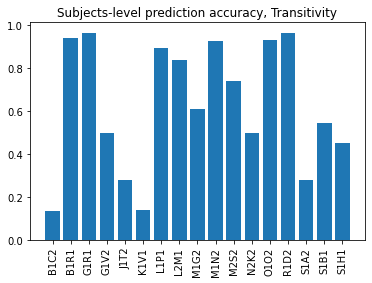

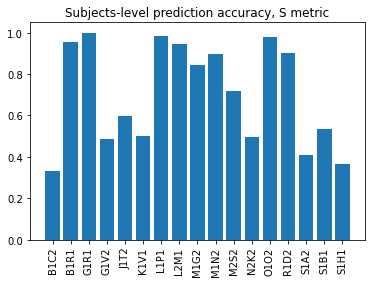

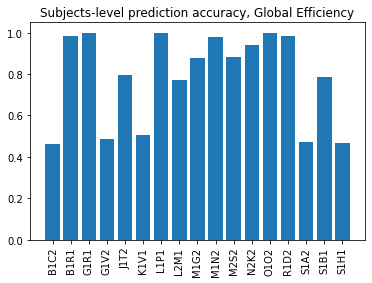

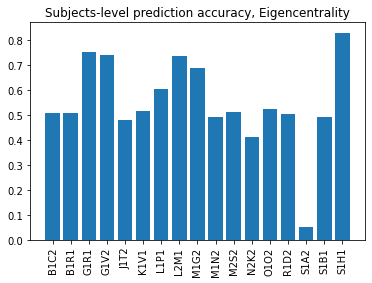

In [17]:
# print(
#     lmd.dict_to_str(
#         cross_subjects_informativeness_arr[-1].acc()
#     )
# )

names = ['Transitivity', 'S metric', 'Global Efficiency', 'Eigencentrality']

for name, info in zip(names, cross_subjects_informativeness_arr):

    acc = dict(
        sorted(
            info.acc().items(),
            key=lambda item: item[0]
        )
    )

    plt.bar(
        acc.keys(),
        acc.values()
    )
    plt.xticks(rotation=90)
    # plt.xticks(range(len(info.acc().keys())))
    plt.title(f'Subjects-level prediction accuracy, {name}')
    plt.show()


In [58]:
series = list()
names = ['Transitivity, acc, %', 'S metric, acc, %', 'Global Efficiency, acc, %', 'Eigencentrality, acc, %']
for info in cross_subjects_informativeness_arr:
    series.append(
        pd.Series(
            dict(
                sorted(
                    info.acc().items(),
                    key=lambda item: item[0]
                )
            )
        )
    )


df = pd.DataFrame(series, index=names)

df = df.T
print(df)
df.to_csv('/home/user/Documents/Engel1&2_Subject_informativeness.csv')

      Transitivity, acc, %  S metric, acc, %  Global Efficiency, acc, %  \
B1C2              0.140903          0.316120                   0.446673   
B1R1              0.931582          0.950452                   0.981475   
G1R1              1.000000          0.981705                   1.000000   
G1V2              0.509396          0.499457                   0.494752   
J1T2              0.289309          0.600242                   0.796012   
K1V1              0.127229          0.501006                   0.502389   
L1P1              0.908161          0.981132                   1.000000   
L2M1              0.821042          0.949617                   0.781943   
M1G2              0.583680          0.844151                   0.886233   
M1N2              0.938768          0.883993                   0.976976   
M2S2              0.728738          0.717525                   0.871956   
N2K2              0.503739          0.500679                   0.939035   
O1O2              0.92007

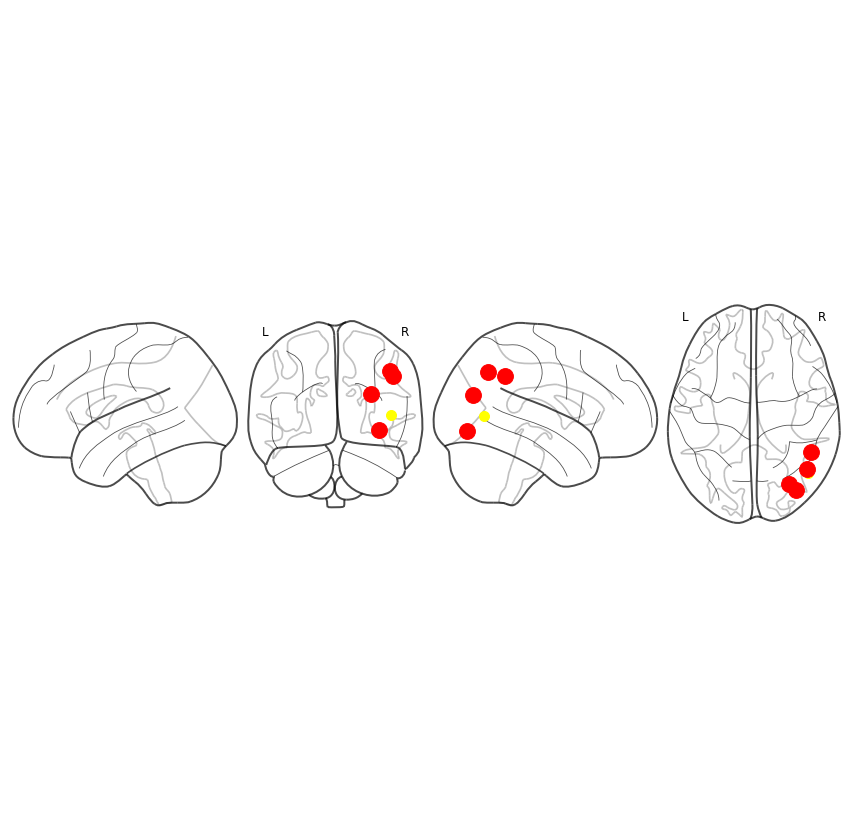

In [22]:
for subject in subjects:
    if subject.name == 'B1C2':
        fig, ax = plt.subplots(figsize=(15,15))
        display = nplt.plot_glass_brain(None, display_mode='lyrz', figure=fig, axes=ax)
        nodes = [node.center_coordinates for node in subject.nodes if node.label.name == 'S_occipital_ant-rh']
        resected = [node.center_coordinates for node in subject.nodes if node.type == 'resected' and node.label.name != 'S_occipital_ant-rh']
        display.add_markers(np.array(nodes), marker_color="yellow", marker_size=100)
        display.add_markers(np.array(resected), marker_color="red", marker_size=250)
        plt.show()

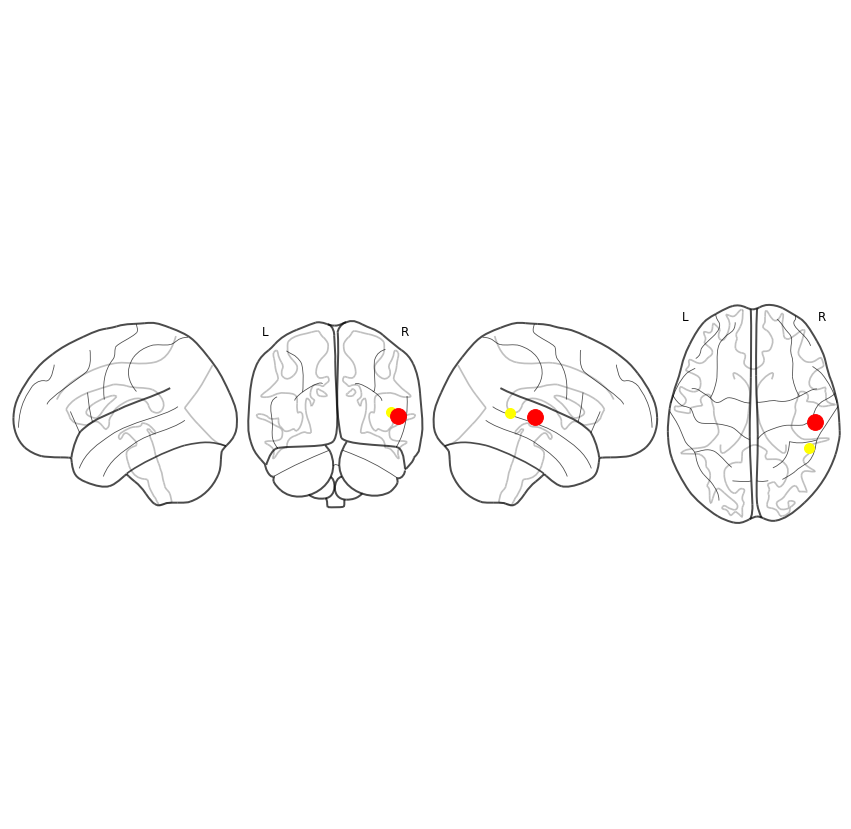

In [27]:
for subject in subjects:
    if subject.name == 'B1R1':
        fig, ax = plt.subplots(figsize=(15,15))
        display = nplt.plot_glass_brain(None, display_mode='lyrz', figure=fig, axes=ax)
        nodes = [node.center_coordinates for node in subject.nodes if node.label.name == 'S_temporal_sup-rh']
        resected = [node.center_coordinates for node in subject.nodes if node.type == 'resected' and node.label.name != 'S_temporal_sup-rh']
        display.add_markers(np.array(nodes), marker_color="yellow", marker_size=100)
        display.add_markers(np.array(resected), marker_color="red", marker_size=250)
        plt.show()

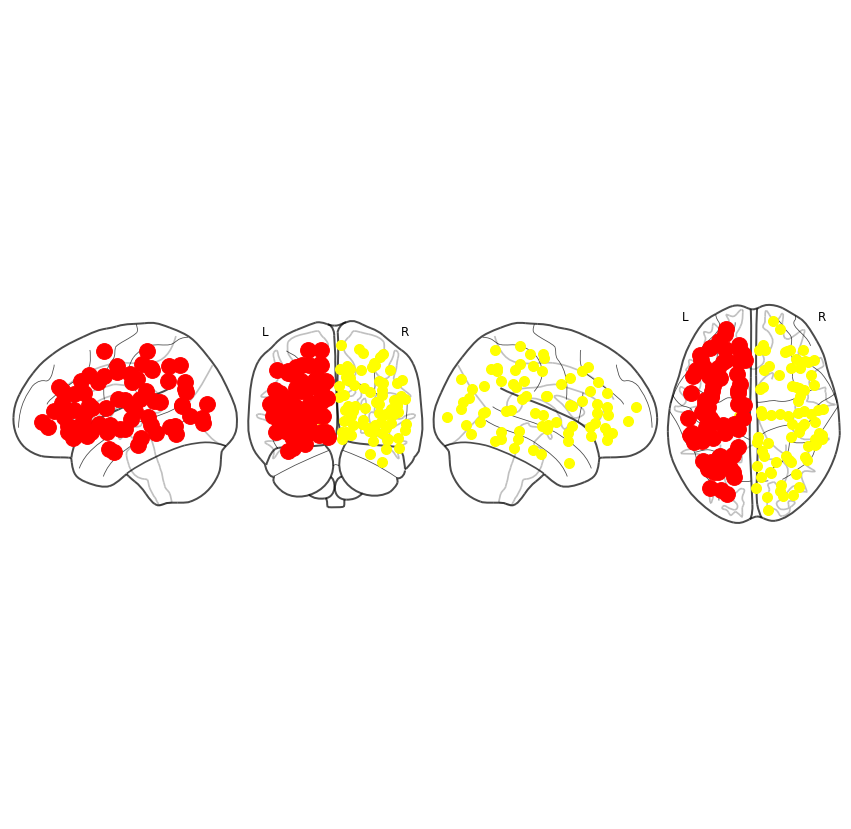

In [5]:

for subject in subjects:
    if subject.name == 'S1U3':
        fig, ax = plt.subplots(figsize=(15,15))
        display = nplt.plot_glass_brain(None, display_mode='lyrz', figure=fig, axes=ax)
        resected = [node.center_coordinates for node in subject.nodes if node.type == 'resected']
        spared = [node.center_coordinates for node in subject.nodes if node.type == 'spared']
        display.add_markers(np.array(spared), marker_color="yellow", marker_size=100)
        display.add_markers(np.array(resected), marker_color="red", marker_size=250)
        plt.show()
